In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Documents/GaussianProcessNode`


In [23]:
using Revise 
using StableRNGs, GraphPPL,ReactiveMP, RxInfer, Random, Distributions, LinearAlgebra, Plots
using Flux, Zygote, ForwardDiff
using SpecialFunctions, ForwardDiff, Optim
using BenchmarkTools
import KernelFunctions: SqExponentialKernel, Matern52Kernel, with_lengthscale, Kernel, kernelmatrix  
import ReactiveMP: GaussHermiteCubature
# import Functors: @functor

## Prepare data 

In [1076]:
function generate_data(n,x_0, f_gp, σ_x, σ_y)
    y=[]
    x = []
    obs = []
    x_prev = x_0
    for i=1:n
        x_t = σ_x * randn() 
        temp = x_t * exp(f_gp[i])  
        push!(y,temp)
        push!(x,x_t)    
        push!(obs, temp + σ_y*randn())
    end
    return x, y , obs
end

generate_data (generic function with 1 method)

In [1183]:
Random.seed!(1)
σ_x = 2pi/10 
σ_y = 0.01 ## we assume low noise for now
x_init = 0.0

N = 300; #data length
n = 300; #lenght of the axis of gp 
meanf = (x) -> 1.0;
kernel(θ) = 0.5*with_lengthscale(SqExponentialKernel(),θ)
tmin,tmax = 0., 1.0
time_range = collect(range(tmin, tmax; length=n));

θ_gp = 0.03
Cov_mat = kernelmatrix(kernel(θ_gp),time_range,time_range) + 1e-8*I;
gp = MvNormal(meanf.(time_range), Cov_mat)
f_test = rand(gp)

#Observe data 
pos = sort(randperm(n)[1:N]); # position where we observe data
time_train = time_range[pos]
f_train = f_test[pos];
cov_strategy = CovarianceMatrixStrategy(FullCovarianceStrategy())

CovarianceMatrixStrategy{FullCovarianceStrategy{Vector{Int64}, Nothing}}(FullCovarianceStrategy{Vector{Int64}, Nothing}(Int64[], nothing, [1.0;;], ReactiveMP.GPCache(Dict{Tuple{Symbol, Tuple{Int64, Int64}}, Matrix{Float64}}(), Dict{Tuple{Symbol, Int64}, Vector{Float64}}())))

In [1184]:
#Generate data 
x_true_state,y_true_state,y_data = generate_data(N,x_init,f_train,σ_x,σ_y);

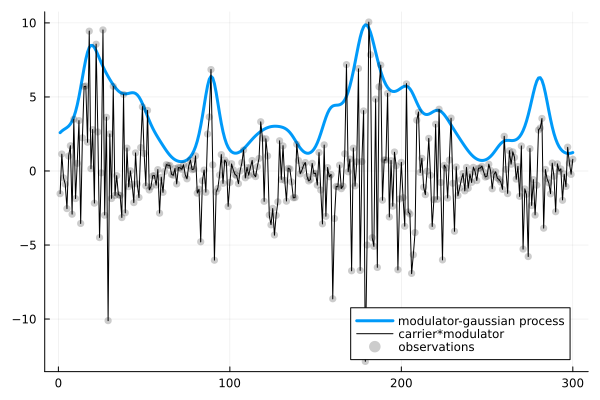

In [1185]:
plot(exp.(f_train), label="modulator-gaussian process",linewidth=3.0)
plot!(y_true_state,label="carrier*modulator",color=:black)

scatter!(y_data, color=:black,label = "observations",alpha=0.2)

## Specify model

In [1186]:
#Exponentiate function 
struct MyExponential end

@node MyExponential Deterministic [ y,x ]   ## x: input,  y: output

In [1187]:
### rule for y 
##TODO: this rule needs to be investigated for speed vs. accuracy 
@rule MyExponential(:y, Marginalisation) (m_x::GaussianProcess, meta::ProcessMeta) = begin
    index = meta.index
    m_gp, cov_gp = mean_cov(m_x.finitemarginal)
    μ_in = m_gp[index]
#     @show index
    var_in = cov_gp[index,index]
    kernelf = m_x.kernelfunction
    meanf   = m_x.meanfunction
    test    = m_x.testinput
    train   = m_x.traininput
    cov_strategy = m_x.covariance_strategy
    x_u = m_x.inducing_input
    mμ, var_μ = ReactiveMP.predictMVN(cov_strategy, kernelf,meanf,test,[train[index]],m_gp, x_u) #this returns negative variance 
    μ_in = mμ[1]
    var_μ[1] < 0. ? var_in = 1 : var_in = var_μ[1]
    return LogNormal(μ_in, var_in)
end

### rule for x
@rule MyExponential(:x, Marginalisation) (m_y::ContinuousUnivariateLogPdf, meta::ProcessMeta) = begin
    log_pdf = (x) -> logpdf(m_y,exp(x))
    return ContinuousUnivariateLogPdf(log_pdf)
end

@rule MyExponential(:y, Marginalisation) (m_x::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    return LogNormal(mean(m_x), var(m_x))
end
    
@rule MyExponential(:x, Marginalisation) (m_y::UnivariateGaussianDistributionsFamily, meta::ProcessMeta) = begin 
    log_pdf = (x) -> logpdf(m_y,exp(x))
    return ContinuousUnivariateLogPdf(log_pdf)
end

In [1188]:
#Test with GP with fixed hyperparameters
@model function randomwalk_gp(n, gp_kernel,gp_mean, train,test, gpstrategy, σ_x)
    x = randomvar(n)
    f = randomprocess(test, train, gpstrategy)
    y = datavar(Float64,n)
    g = randomvar(n)
#     w = randomvar(n)
#     θ ~ NormalMeanVariance(log(θ_gp), 2.)

    f ~ GaussianProcess(gp_mean, gp_kernel, log(θ_gp))
#     v ~ GammaShapeScale(1.01,1.0)
    for i=1:n 
        x[i] ~ NormalMeanVariance(0.0,σ_x^2)
        g[i] ~ MyExponential(f) where {meta = ProcessMeta(i)}
        y[i] ~ NormalMeanPrecision(x[i]*g[i], 1/σ_y^2)
    end
end

In [1189]:
@rule typeof(*)(:A, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_in::Tuple, meta::TinyCorrection) = begin 
    μ_in = mean(m_in[1])
    var_in = mean(m_in[2])
    
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)) - 0.5*log(2π * (var_in + var_out / x^2))  -1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)
    return ContinuousUnivariateLogPdf(backwardpass)
end

@rule typeof(*)(:in, Marginalisation) (m_out::UnivariateGaussianDistributionsFamily, m_A::UnivariateGaussianDistributionsFamily, meta::TinyCorrection) = begin 
    μ_in, var_in = mean_var(m_A)
    μ_out, var_out = mean_var(m_out)
    backwardpass = (x) -> -log(abs(x)) - 0.5*log(2π * (var_in + var_out / x^2))  - 1/2 * (μ_out / x - μ_in)^2 / (var_in + var_out / x^2)

    return ContinuousUnivariateLogPdf(backwardpass)
end



## Rule for multiplication node

In [1190]:
#use Gaussian GaussHermiteCubature to approximate 
#Temporarily put here 
function ReactiveMP.prod(::ProdAnalytical, left::UnivariateGaussianDistributionsFamily, right::ContinuousUnivariateLogPdf) 
    #we use Gaussian Hermite Cubature here, not ProdAnalytical 
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(right.logpdf(z)), mean(left), var(left))
    return NormalMeanVariance(m,v)
end

function ReactiveMP.prod(::ProdAnalytical, left::ContinuousUnivariateLogPdf, right::UnivariateGaussianDistributionsFamily)
    meta = GaussHermiteCubature(121)
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(left.logpdf(z)), mean(right), var(right))
    return NormalMeanVariance(m,v)
end

#Look carefully at these two functions 
function ReactiveMP.mean_var(p::ContinuousUnivariateLogPdf)
    res = optimize(x -> -logpdf(p,x),-5,5)
    m0 = res.minimizer
    meta = GaussHermiteCubature(121)
    v0  = 5.0
    m,v = ReactiveMP.approximate_meancov(meta, z -> exp(p.logpdf(z)-logpdf(NormalMeanVariance(m0,v0),z)), m0, v0)
    
    return m,v
end

Distributions.mean(p::ContinuousUnivariateLogPdf) = mean_var(p)[1]
Distributions.var(p::ContinuousUnivariateLogPdf) = mean_var(p)[2]


function ReactiveMP.prod(::ProdAnalytical, left::LogNormal, right::ContinuousUnivariateLogPdf) 
    sample_left = rand(left,5000)
    weights = [exp(logpdf(right,sample_left[i])) for i=1:5000]
    weight = weights / sum(weights)
    m = sum(weight .*sample_left)
    v = sum(weight .* (sample_left .- m).^2)
    return NormalMeanVariance(m,v)
end

@rule NormalMeanVariance(:v, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanVariance(:v, Marginalisation) (q_out=d_out, q_μ=q_μ, ) 
end

@rule NormalMeanVariance(:out, Marginalisation) (q_μ::PointMass, m_v::InverseGamma, ) = begin 
    return  @call_rule NormalMeanVariance(:out, Marginalisation) (q_μ=q_μ, q_v=m_v, )
end

@rule NormalMeanPrecision(:τ, Marginalisation) (m_out::ContinuousUnivariateLogPdf, q_μ::PointMass, ) = begin 
    m,v = mean_var(m_out)
    d_out = NormalMeanVariance(m,v)
    return @call_rule NormalMeanPrecision(:τ, Marginalisation) (q_out=d_out, q_μ =q_μ , )
end

@rule NormalMeanPrecision(:out, Marginalisation) (q_μ::PointMass, m_τ::Gamma, ) = begin 
    return  @call_rule NormalMeanPrecision(:out, Marginalisation) (q_μ=q_μ, q_τ=m_τ, )
end

@rule GaussianProcess(:params, Marginalisation) (m_out::GaussianProcess, q_meanfunc::PointMass, q_kernelfunc::PointMass, q_params::UnivariateGaussianDistributionsFamily, meta::Unscented) = begin 
    return @call_rule GaussianProcess(:params, Marginalisation) (q_out=m_out, q_meanfunc=q_meanfunc, q_kernelfunc=q_kernelfunc, q_params=q_params, meta=meta)
end

In [1191]:
nits = 5

iresult = inference(
    model = randomwalk_gp(length(y_data), kernel, meanf, time_train,time_range, cov_strategy, σ_x),
    initmessages = (f = GaussianProcess(meanf,kernel(θ_gp),MvNormalMeanCovariance(zeros(n),Cov_mat),time_range,time_train,Float64[], CovarianceMatrixStrategy(FullCovarianceStrategy())),),
    iterations = nits,  
    data  = (y = y_data,),
    free_energy = false
)



Inference results:
  Posteriors       | available for (f, g, x)


In [1192]:
mgp = mean(iresult.posteriors[:f][end].finitemarginal)
vgp = var(iresult.posteriors[:f][end].finitemarginal)
expvgp = exp.( mgp .+ vgp)
expmgp = exp.(mgp);

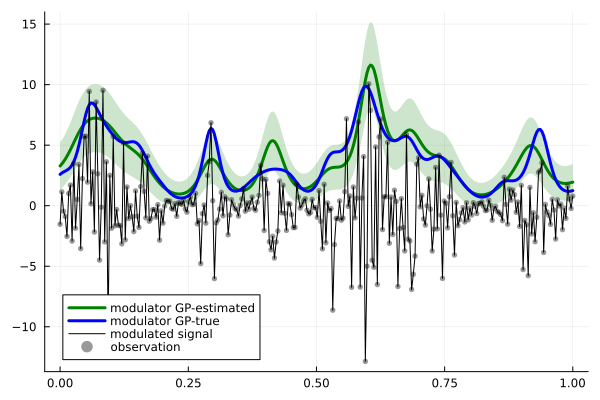

In [1193]:
plot(time_range,expmgp,ribbon=sqrt.(expvgp),linewidth=3.0,label="modulator GP-estimated",fillalpha=0.2,color=:green)
plot!(time_range,exp.(f_test), label="modulator GP-true",linewidth=3.0,color=:blue)
plot!(time_train,y_true_state, label="modulated signal",color=:black)
scatter!(time_train,y_data, label="observation",color=:black,alpha=0.4,ms=3,legend=:bottomleft)

